In [ ]:
import core.AssignmentTransformer as TransformerAnalysis
from core.DataLoader import DataPreprocessor
import core.AssignmentKFold as KFold
import numpy as np
from importlib import reload
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
MAX_JETS = 4
PLOTS_DIR = f"plots/"
import os
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

DataProcessor = DataPreprocessor(jet_features=["ordered_jet_pt", "ordered_jet_e", "ordered_jet_phi", "ordered_jet_eta", "ordered_jet_b_tag","m_l1j", "m_l2j", "dR_l1j", "dR_l2j"], 
                                lepton_features=["lep_pt","lep_e", "lep_eta", "lep_phi"],
                                jet_truth_label="ordered_event_jet_truth_idx", 
                                lepton_truth_label="event_lepton_truth_idx", 
                                global_features = ["met_met_NOSYS","met_phi_NOSYS"], 
                                max_leptons=2, 
                                max_jets = MAX_JETS, 
                                non_training_features= ["truth_ttbar_mass", "truth_ttbar_pt", "N_jets"], 
                                event_weight="weight_mc_NOSYS")
DataProcessor.load_data("/data/dust/group/atlas/ttreco/full_training.root", "reco", max_events=100000)
DataProcessor.prepare_data()
DataProcessor.normalise_data()
DataProcessor.split_data(0.2)

2025-06-20 11:52:20.015358: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 11:52:20.019878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 11:52:20.033314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750413140.055282 4143385 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750413140.061985 4143385 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750413140.079312 4143385 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
reload(TransformerAnalysis)
reload(KFold)

# TransformerMatcher = KFold.KFoldEvaluation(TransformerAnalysis.TransformerJetMatcher, DataProcessor)
TransformerMatcher = TransformerAnalysis.TransformerJetMatcher(DataProcessor); TransformerMatcher.load_data(*DataProcessor.get_data())
# TransformerMatcher.load_model("CONDOR/plots_Transformer_hpo/8_2_1_8_0/jet_matcher_1.keras")
TransformerMatcher.build_model(
    hidden_size=16,
    lep_dim=4,
    global_dim=2,
    jet_embedding_layers=2,
    lepton_embedding_layers=2,
    global_embedding_layers=2,
    attention_blocks=2,
    ff_layers=3,
    n_heads=6,
    dropout_rate=0,
    regularization_lambda=0.001,
)
TransformerMatcher.compile_model(
    lambda_excl=0, optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
TransformerMatcher.model.summary()

New TransformerJetMatcher model initialized.


2025-06-20 11:52:42.584883: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "TransformerJetMatcher"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lepton (InputLayer) │ (None, 2, 4)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global (InputLayer) │ (None, 1, 2)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lepton_embedding_1  │ (None, 2, 4)      │         20 │ lepton[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_embedding_1  │ (None, 1, 2)      │          6 │ global[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet (InputLayer)    │ (None, 4, 9)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lepton_embedding_d… │ (None, 2, 4)      │          0 │ lepton_embedding… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_embedding_d… │ (None, 1, 2)      │          0 │ global_embedding… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding_1     │ (None, 4, 16)     │        160 │ jet[0][0]         │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lepton_embedding_2  │ (None, 2, 4)      │         20 │ lepton_embedding… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_embedding_2  │ (None, 1, 2)      │          6 │ global_embedding… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding_drop… │ (None, 4, 16)     │          0 │ jet_embedding_1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lepton_embedding_d… │ (None, 2, 4)      │          0 │ lepton_embedding… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_embedding_d… │ (None, 1, 2)      │          0 │ global_embedding… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding_2     │ (None, 4, 16)     │        272 │ jet_embedding_dr… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8)         │          0 │ lepton_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 2)         │          0 │ global_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding_drop… │ (None, 4, 16)     │          0 │ jet_embedding_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 4, 8)      │          0 │ reshape_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,966 (66.27 KB)

 Trainable params: 16,966 (66.27 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
TransformerMatcher.train_model(epochs=100,
                                batch_size=128,
                                verbose=1,
                                weight = "sample",
                                callbacks = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50, restore_best_weights=True, mode ="max"))


Starting training...
Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7576 - loss: 0.2263 - val_accuracy: 0.7587 - val_loss: 0.1198
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8068 - loss: 0.1136 - val_accuracy: 0.8445 - val_loss: 0.1101
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8172 - loss: 0.1058 - val_accuracy: 0.7725 - val_loss: 0.1048
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8162 - loss: 0.1029 - val_accuracy: 0.8609 - val_loss: 0.1022
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8186 - loss: 0.1014 - val_accuracy: 0.8565 - val_loss: 0.0999
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8165 - loss: 0.1007 - val_accuracy: 0.8790 - val_loss: 0.1005
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8260 - loss: 0.1002 - val_accuracy: 0.8537 - val_loss: 0.1002
Epoch 8/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.

(<Figure size 500x1000 with 2 Axes>,
 array([<Axes: title={'center': 'accuracy'}, xlabel='Epochs', ylabel='accuracy'>,
        <Axes: title={'center': 'loss'}, xlabel='Epochs', ylabel='loss'>],
       dtype=object))

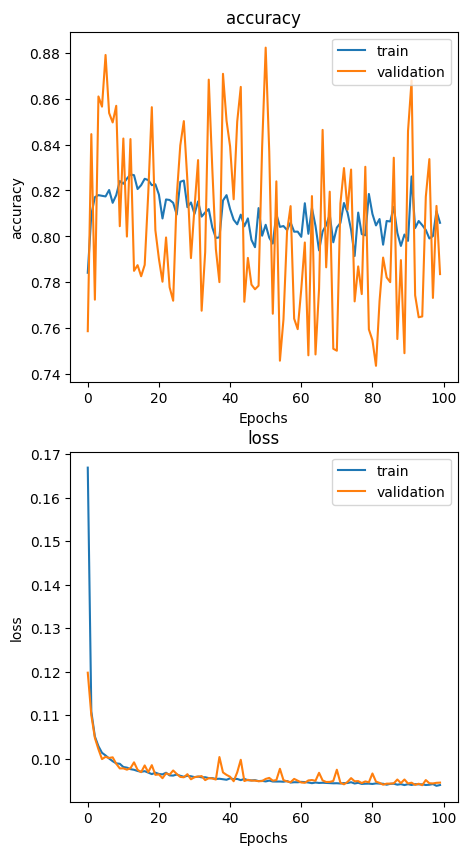

In [4]:
TransformerMatcher.plot_history()

[[[0.26998514 0.72814906]
  [0.73001486 0.2718509 ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.25450796 0.2370251 ]
  [0.4880584  0.5418261 ]
  [0.25743365 0.22114874]
  [0.         0.        ]]

 [[0.17498632 0.16523303]
  [0.47494495 0.22074278]
  [0.17507151 0.4487903 ]
  [0.17499721 0.1652339 ]]

 ...

 [[0.73095405 0.26910594]
  [0.26904595 0.7308941 ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.73074013 0.26922637]
  [0.26925984 0.7307736 ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.27061754 0.7284072 ]
  [0.72938246 0.2715928 ]
  [0.         0.        ]
  [0.         0.        ]]]


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Confusion Matrix for Lepton 1 (Bootstrap)'}, xlabel='Predicted Label', ylabel='True Label'>,
        <Axes: title={'center': 'Confusion Matrix for Lepton 2 (Bootstrap)'}, xlabel='Predicted Label', ylabel='True Label'>],
       dtype=object))

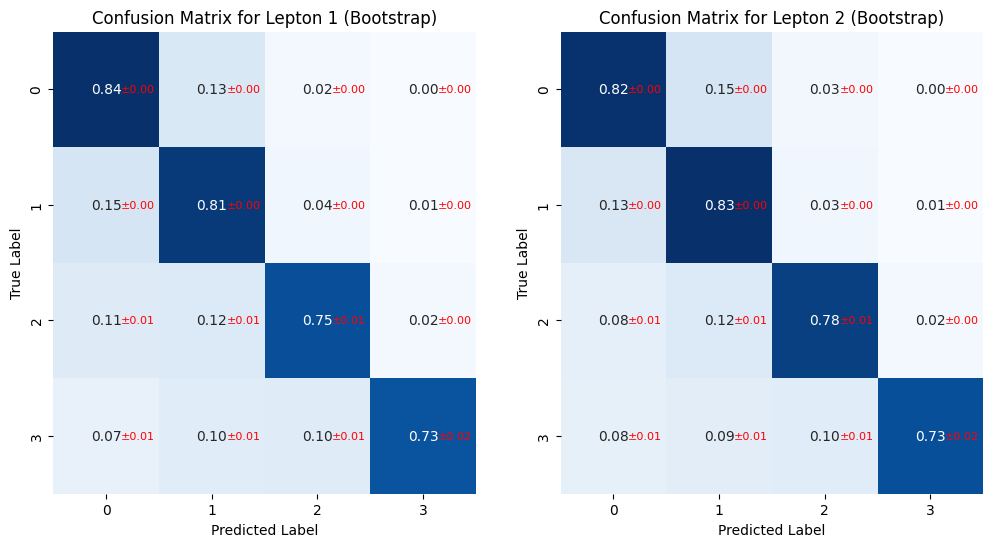

In [7]:
TransformerMatcher.plot_confusion_matrix()

[[[0.26916897 0.73060685]
  [0.730831   0.26939312]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.21912827 0.41062573]
  [0.56184036 0.42853794]
  [0.21903132 0.1608363 ]
  [0.         0.        ]]

 [[0.50008816 0.2691111 ]
  [0.49991184 0.7308888 ]
  [0.         0.        ]
  [0.         0.        ]]

 ...

 [[0.73095745 0.26910704]
  [0.26904252 0.73089296]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.7304607  0.26952395]
  [0.26953924 0.73047596]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.2699343  0.7294825 ]
  [0.7300657  0.27051756]
  [0.         0.        ]
  [0.         0.        ]]]
[[[0.26999858 0.72825706]
  [0.73000145 0.27174285]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.30316755 0.67526823]
  [0.6968324  0.3247317 ]
  [0.         0.        ]
  [0.         0.        ]]

 [[0.21253869 0.18727529]
  [0.57478917 0.3041726 ]
  [0.21267204 0.50855213]
  [0.         0.        ]]

 ...

 [[0.73095566 0.26910597]
  [0.269

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Lepton 1 Accuracy'}, ylabel='Importance Score'>,
        <Axes: title={'center': 'Lepton 2 Accuracy'}, ylabel='Importance Score'>,
        <Axes: title={'center': 'Combined Accuracy'}, ylabel='Importance Score'>],
       dtype=object))

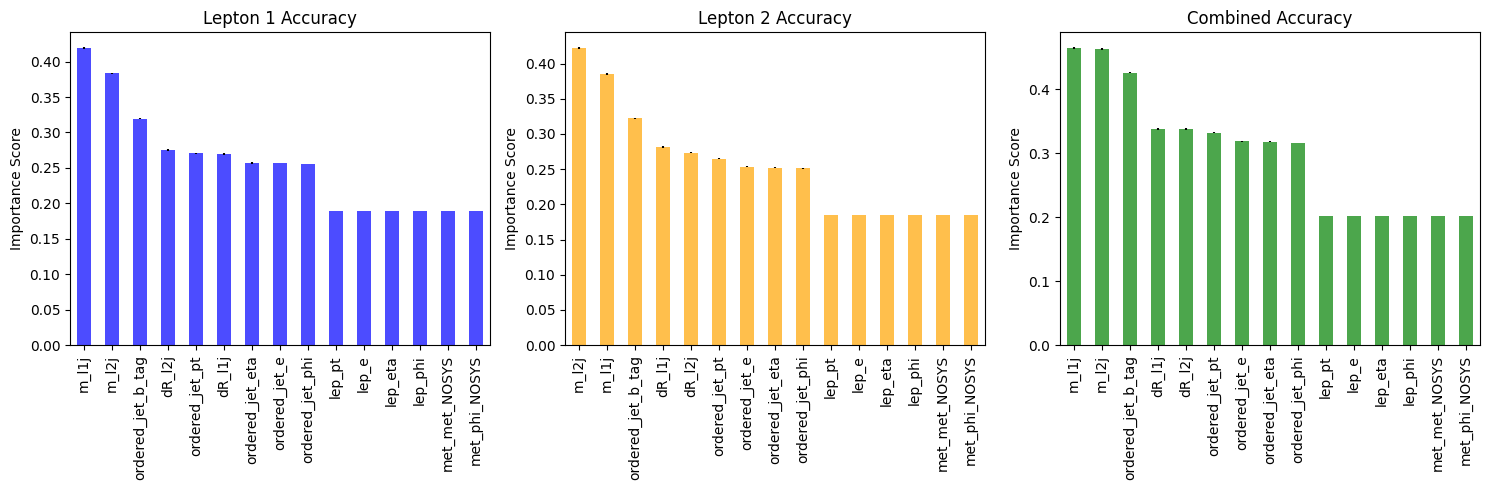

In [8]:
TransformerMatcher.plot_permutation_importance(shuffle_number=5)